In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (849).jpg
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (276).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (971).jpg
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (864).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (282).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (566).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (689).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (616).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (258).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image 

In [2]:
dataset_path ='/kaggle/input/top-agriculture-crop-disease/Crop Diseases'

In [3]:
import numpy as np
import pandas as pd
import torch
import os
import cv2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),     
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225] )
    
])

In [5]:
for i in os.listdir('/kaggle/input/top-agriculture-crop-disease/Crop Diseases'):
    x=os.listdir('/kaggle/input/top-agriculture-crop-disease/Crop Diseases'+f'/{i}')
    print(i, '-', len(x))

Corn___Northern_Leaf_Blight - 985
Wheat___Yellow_Rust - 924
Sugarcane_Bacterial Blight - 100
Potato___Healthy - 152
Rice___Neck_Blast - 1000
Corn___Healthy - 1162
Wheat___Brown_Rust - 902
Corn___Gray_Leaf_Spot - 513
Rice___Brown_Spot - 613
Sugarcane_Red Rot - 100
Sugarcane_Healthy - 100
Wheat___Healthy - 1116
Rice___Leaf_Blast - 977
Potato___Late_Blight - 1000
Rice___Healthy - 1488
Corn___Common_Rust - 1192
Potato___Early_Blight - 1000


In [6]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

class ClassDependentAugment:
    def __init__(self, min_samples):
        self.min_samples = min_samples
        
    def __call__(self, img, class_idx):
        base_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)
        ])
        
        # Aggressive augment for classes with <100 samples
        if self.min_samples[class_idx] < 650:
            return transforms.Compose([
                base_transform,
                transforms.RandomRotation(40),
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
                transforms.RandomAffine(0, shear=20),
                transforms.RandomPerspective(distortion_scale=0.5),
                transforms.GaussianBlur(3)
            ])(img)
            
        return base_transform(img)


class BalancedPlantDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, target_size=1000):
        self.dataset = datasets.ImageFolder(root_dir)
        self.class_counts = np.bincount([s[1] for s in self.dataset.samples])
        self.target_size = target_size
        self.class_weights = self._compute_class_weights()
        
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor()
        ])
        self.augmentor = ClassDependentAugment(self.class_counts)

    def _compute_class_weights(self):
        weights = [self.target_size / count for count in self.class_counts]
        return torch.DoubleTensor(weights)
    
    def __len__(self):
        return self.target_size * len(self.class_counts)
    
    def __getitem__(self, idx):
        class_idx = idx % len(self.class_counts)
        actual_idx = np.random.choice(
            np.where(np.array(self.dataset.targets) == class_idx)[0]
        )
        img, label = self.dataset[actual_idx]
        
        img = self.augmentor(img, class_idx)
        return self.transform(img), label


In [7]:
# --- helper dataset for a list of paths ------------------------------
from PIL import Image
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform=None, augmenter=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.augmenter = augmenter

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.augmenter:
            img = self.augmenter(img, label)
        if self.transform:
            img = self.transform(img)
        return img, label

# --- stratified balance-and-split function ---------------------------
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random

def split_dataset_by_class(dataset, target_size=1500, val_split=0.2, seed=42):
    """
    • Oversamples / downsamples every class to *target_size* images.
    • Returns train- and val-datasets with the same transform.
    """
    # 1️⃣ group (path, label) pairs by class
    class_to_items = defaultdict(list)
    for path, label in dataset.dataset.samples:
        class_to_items[label].append((path, label))

    # 2️⃣ balance each class to exactly target_size
    balanced_items = []
    for label, items in class_to_items.items():
        if len(items) < target_size:                    # oversample
            reps = (target_size // len(items)) + 1
            items = (items * reps)[:target_size]
        elif len(items) > target_size:                  # down-sample
            items = random.sample(items, target_size)
        balanced_items.extend(items)

    # 3️⃣ stratified split
    paths, labels = zip(*balanced_items)
    train_p, val_p, train_l, val_l = train_test_split(
        paths, labels,
        test_size=val_split,
        stratify=labels,
        random_state=seed
    )

    # 4️⃣ wrap back into torch Datasets
    train_ds = CustomImageDataset(train_p, train_l,
                                  transform=dataset.transform,
                                  augmenter=dataset.augmentor)   # keep aug
    val_ds   = CustomImageDataset(val_p,   val_l,
                                  transform=dataset.transform,
                                  augmenter=None)                # no aug
    return train_ds, val_ds


In [8]:
# common transform (same as you used earlier)
common_tf = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225])
])

# 1️⃣ base balanced dataset (uses ClassDependentAugment inside)
base_ds = BalancedPlantDataset(
    root_dir="/kaggle/input/top-agriculture-crop-disease/Crop Diseases",
    target_size=1500            # <-- your new target per class
)

# 2️⃣ split into train / validation (80 / 20)
train_ds, val_ds = split_dataset_by_class(
    base_ds, target_size=800,  # keep in sync
    val_split=0.2
)

# 3️⃣ DataLoaders
train_loader = DataLoader(train_ds,
                          batch_size=64,
                          shuffle=True,          # plain shuffle; sampler not needed
                          num_workers=4,
                          pin_memory=True)

val_loader   = DataLoader(val_ds,
                          batch_size=64,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)

print(f"Train images : {len(train_ds)}")
print(f"Val   images : {len(val_ds)}")


Train images : 10880
Val   images : 2720


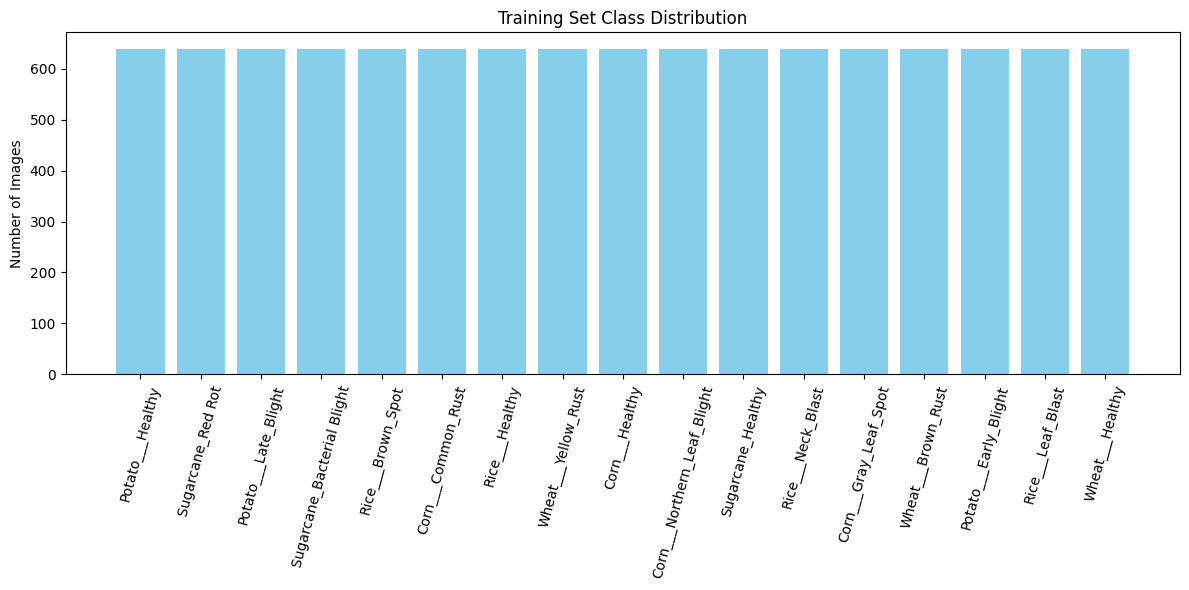

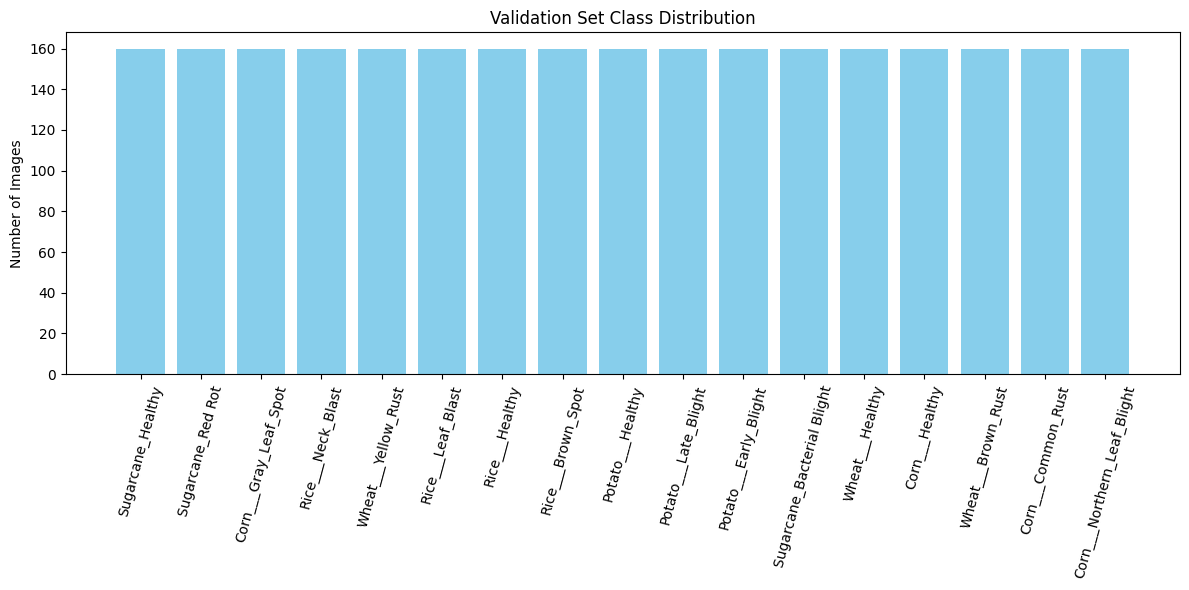

In [9]:
from collections import Counter
import matplotlib.pyplot as plt


class_names = os.listdir('/kaggle/input/top-agriculture-crop-disease/Crop Diseases')  # uses ImageFolder class_to_idx

def plot_class_distribution(labels, title):
    counter = Counter(labels)
    # Convert to class names
    name_counts = {class_names[k]: v for k, v in counter.items()}
    
    # Bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(name_counts.keys(), name_counts.values(), color='skyblue')
    plt.xticks(rotation=75)
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

# Get label list from both datasets
train_labels = train_ds.labels
val_labels   = val_ds.labels

# Plot distributions
plot_class_distribution(train_labels, "Training Set Class Distribution")
plot_class_distribution(val_labels, "Validation Set Class Distribution")


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import numpy as np


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA available: True
Device: Tesla T4


In [13]:
# Should complete in a few seconds if GPU is working
dummy = torch.randn(10000, 10000, device=device)
print(dummy @ dummy)


tensor([[ -55.7754,  -22.0897,   16.1796,  ..., -160.1480,  163.1788,
          -13.4394],
        [  -1.0890,   21.7440,   41.7205,  ...,   52.0564, -127.1746,
            0.9047],
        [-169.8940,   -5.0328,  118.0176,  ...,   76.9583,  -73.3593,
          -69.1179],
        ...,
        [  69.6304,  -23.1923,  108.6510,  ..., -115.5711,  -80.0864,
          -29.4111],
        [  45.8384,  -82.3404,   40.4587,  ...,   61.1500,  -26.5001,
           68.6906],
        [ -68.8785,  -41.5000,  196.9954,  ..., -126.2422,   45.6549,
          146.1096]], device='cuda:0')


In [14]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 17)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
def train_model(model, train_loader, val_loader, num_epochs=8):
    os.makedirs('./kaggle/working', exist_ok=True)
    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            #print(f"[DEBUG] Model device: {next(model.parameters()).device}, Batch device: {images.device}")
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        torch.save(model.state_dict(), f'./kaggle/working/inception_model_epoch{epoch}.pth')

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Acc: {val_acc:.4f}")
        print(classification_report(val_labels, val_preds, target_names=class_names))
        print("Confusion Matrix:")
        print(confusion_matrix(val_labels, val_preds))


In [17]:
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np

def evaluate_image_quality(model, loader):
    model.eval()
    sample_images, sample_labels = next(iter(loader))
    img = sample_images[0].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img)
    
    img_np = TF.to_pil_image(sample_images[0]).convert('RGB')
    output_np = img_np  # use GT or compare with reconstruction (if applicable)

    img_arr = np.array(img_np)
    pred_arr = np.array(output_np)

    print("PSNR:", psnr(img_arr, pred_arr))
    print("SSIM:", ssim(img_arr, pred_arr, multichannel=True))
    print("MSE:", np.mean((img_arr - pred_arr) ** 2))


In [18]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))


CUDA available: True
Current device: 0
Device name: Tesla T4


In [19]:
train_model(model, train_loader, val_loader, num_epochs=8)

100%|██████████| 170/170 [1:28:33<00:00, 31.26s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/8
Train Loss: 0.2762, Train Acc: 0.9104
Val Acc: 0.7816
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.98      1.00      0.99       160
        Wheat___Yellow_Rust       1.00      0.02      0.04       160
 Sugarcane_Bacterial Blight       0.98      1.00      0.99       160
           Potato___Healthy       0.51      0.99      0.67       160
          Rice___Neck_Blast       1.00      1.00      1.00       160
             Corn___Healthy       0.00      0.00      0.00       160
         Wheat___Brown_Rust       0.50      1.00      0.67       160
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       160
          Rice___Brown_Spot       0.71      0.93      0.81       160
          Sugarcane_Red Rot       0.52      0.89      0.66       160
          Sugarcane_Healthy       1.00      0.99      1.00       160
            Wheat___Healthy       0.89      0.88      0.89       160
          Rice___Leaf_Blast       1.00

100%|██████████| 170/170 [1:26:32<00:00, 30.54s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/8
Train Loss: 0.1127, Train Acc: 0.9626
Val Acc: 0.7857
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.99      1.00      1.00       160
        Wheat___Yellow_Rust       1.00      0.09      0.16       160
 Sugarcane_Bacterial Blight       0.99      0.84      0.91       160
           Potato___Healthy       0.52      0.99      0.68       160
          Rice___Neck_Blast       1.00      1.00      1.00       160
             Corn___Healthy       0.00      0.00      0.00       160
         Wheat___Brown_Rust       0.50      1.00      0.67       160
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       160
          Rice___Brown_Spot       0.80      0.94      0.86       160
          Sugarcane_Red Rot       0.49      0.91      0.64       160
          Sugarcane_Healthy       1.00      0.99      1.00       160
            Wheat___Healthy       1.00      0.86      0.93       160
          Rice___Leaf_Blast       1.00

100%|██████████| 170/170 [1:29:01<00:00, 31.42s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/8
Train Loss: 0.0815, Train Acc: 0.9712
Val Acc: 0.7908
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       1.00      0.96      0.98       160
        Wheat___Yellow_Rust       0.12      0.01      0.01       160
 Sugarcane_Bacterial Blight       0.99      1.00      1.00       160
           Potato___Healthy       0.50      0.99      0.67       160
          Rice___Neck_Blast       1.00      0.97      0.98       160
             Corn___Healthy       1.00      0.01      0.02       160
         Wheat___Brown_Rust       0.50      1.00      0.66       160
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       160
          Rice___Brown_Spot       0.59      0.99      0.74       160
          Sugarcane_Red Rot       0.57      0.76      0.65       160
          Sugarcane_Healthy       1.00      0.97      0.98       160
            Wheat___Healthy       0.90      0.97      0.93       160
          Rice___Leaf_Blast       0.99

100%|██████████| 170/170 [1:24:09<00:00, 29.70s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/8
Train Loss: 0.0680, Train Acc: 0.9773
Val Acc: 0.7849
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.96      0.99      0.98       160
        Wheat___Yellow_Rust       0.33      0.01      0.01       160
 Sugarcane_Bacterial Blight       1.00      1.00      1.00       160
           Potato___Healthy       0.51      1.00      0.68       160
          Rice___Neck_Blast       1.00      1.00      1.00       160
             Corn___Healthy       0.00      0.00      0.00       160
         Wheat___Brown_Rust       0.50      1.00      0.67       160
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       160
          Rice___Brown_Spot       0.64      0.98      0.77       160
          Sugarcane_Red Rot       0.56      0.81      0.66       160
          Sugarcane_Healthy       1.00      1.00      1.00       160
            Wheat___Healthy       0.91      0.86      0.88       160
          Rice___Leaf_Blast       1.00

100%|██████████| 170/170 [1:26:15<00:00, 30.44s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/8
Train Loss: 0.0567, Train Acc: 0.9794
Val Acc: 0.7574
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       1.00      1.00      1.00       160
        Wheat___Yellow_Rust       1.00      0.01      0.01       160
 Sugarcane_Bacterial Blight       0.94      1.00      0.97       160
           Potato___Healthy       0.50      1.00      0.67       160
          Rice___Neck_Blast       1.00      0.94      0.97       160
             Corn___Healthy       0.00      0.00      0.00       160
         Wheat___Brown_Rust       0.48      0.99      0.65       160
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       160
          Rice___Brown_Spot       0.78      0.93      0.85       160
          Sugarcane_Red Rot       0.50      0.92      0.65       160
          Sugarcane_Healthy       1.00      1.00      1.00       160
            Wheat___Healthy       0.95      0.73      0.83       160
          Rice___Leaf_Blast       1.00

100%|██████████| 170/170 [1:30:04<00:00, 31.79s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/8
Train Loss: 0.0690, Train Acc: 0.9785
Val Acc: 0.7923
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.99      1.00      1.00       160
        Wheat___Yellow_Rust       1.00      0.03      0.05       160
 Sugarcane_Bacterial Blight       0.98      1.00      0.99       160
           Potato___Healthy       0.51      0.99      0.68       160
          Rice___Neck_Blast       0.98      1.00      0.99       160
             Corn___Healthy       0.00      0.00      0.00       160
         Wheat___Brown_Rust       0.50      1.00      0.67       160
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       160
          Rice___Brown_Spot       0.69      0.97      0.81       160
          Sugarcane_Red Rot       0.55      0.87      0.67       160
          Sugarcane_Healthy       0.98      1.00      0.99       160
            Wheat___Healthy       0.97      0.97      0.97       160
          Rice___Leaf_Blast       1.00

100%|██████████| 170/170 [1:30:13<00:00, 31.85s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/8
Train Loss: 0.0505, Train Acc: 0.9820
Val Acc: 0.8007
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.95      0.99      0.97       160
        Wheat___Yellow_Rust       1.00      0.03      0.06       160
 Sugarcane_Bacterial Blight       1.00      1.00      1.00       160
           Potato___Healthy       0.52      1.00      0.68       160
          Rice___Neck_Blast       1.00      1.00      1.00       160
             Corn___Healthy       0.00      0.00      0.00       160
         Wheat___Brown_Rust       0.50      1.00      0.67       160
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       160
          Rice___Brown_Spot       0.71      0.97      0.82       160
          Sugarcane_Red Rot       0.52      0.86      0.65       160
          Sugarcane_Healthy       1.00      1.00      1.00       160
            Wheat___Healthy       0.86      1.00      0.92       160
          Rice___Leaf_Blast       0.94

100%|██████████| 170/170 [1:31:29<00:00, 32.29s/it]


Epoch 8/8
Train Loss: 0.0552, Train Acc: 0.9823
Val Acc: 0.7934
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.99      1.00      0.99       160
        Wheat___Yellow_Rust       0.00      0.00      0.00       160
 Sugarcane_Bacterial Blight       1.00      1.00      1.00       160
           Potato___Healthy       0.50      1.00      0.67       160
          Rice___Neck_Blast       1.00      1.00      1.00       160
             Corn___Healthy       0.00      0.00      0.00       160
         Wheat___Brown_Rust       0.50      1.00      0.67       160
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       160
          Rice___Brown_Spot       0.62      0.97      0.76       160
          Sugarcane_Red Rot       0.55      0.78      0.65       160
          Sugarcane_Healthy       1.00      1.00      1.00       160
            Wheat___Healthy       0.99      0.93      0.96       160
          Rice___Leaf_Blast       1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
test_img='/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight/image (849).jpg'
pic=load_img(test_img,target_size=(256,256,3))
plt.imshow(pic)
output(test_img)

NameError: name 'load_img' is not defined

In [ ]:
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Sugarcane_Red Rot/S_RR (95).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Sugarcane_Red Rot/S_RR (44).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Sugarcane_Red Rot/S_RR (21).JPG
/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Sugarcane_Red Rot/S_RR (91).JPG

In [ ]:
test_img='/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Sugarcane_Bacterial Blight/S_BLB (50).JPG'
pic=load_img(test_img,target_size=(256,256,3))
plt.imshow(pic)
output(test_img)

In [ ]:
test_img='/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Sugarcane_Red Rot/S_RR (21).JPG'
pic=load_img(test_img,target_size=(256,256,3))
plt.imshow(pic)
output(test_img)